In [2]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "6"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
sys.path.append(os.path.abspath(".."))

slurm0-a3nodeset-2
/home/akarsh_sakana_ai/nca-alife/src/science_notebooks
/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/bin/python


In [3]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [4]:
import experiment_utils
import util

# Create Experiment

In [4]:
# group.add_argument("--seed", type=int, default=0)
# group.add_argument("--save_dir", type=str, default=None)

# group = parser.add_argument_group("model")
# group.add_argument("--grid_size", type=int, default=128)
# group.add_argument("--phenotype_size", type=int, default=64)
# group.add_argument("--rollout_steps", type=int, default=256)

# group = parser.add_argument_group("data")
# group.add_argument("--clip_model", type=str, default="clip-vit-base-patch32") # clip-vit-base-patch32 or clip-vit-large-patch14

# group = parser.add_argument_group("optimization")
# group.add_argument("--bs", type=int, default=32)
# group.add_argument("--pop_size", type=int, default=1024)
# group.add_argument("--n_iters", type=int, default=10000)
# group.add_argument("--sigma1", type=float, default=0.1)
# group.add_argument("--sigma2", type=float, default=0.)

# group.add_argument("--start_pattern", type=str, default="5N7KKM")

In [5]:
# cfg_default = dict(
#     seed=0, save_dir=None,
#     grid_size=128, phenotype_size=64, rollout_steps=256,
#     start_pattern="5N7KKM",

#     k_nbrs=1,
#     bs=32, pop_size=1024,
#     n_iters=10000,
#     sigma1=0.1, sigma2=0.,
# )

# seed_sweep = np.arange(4)

# # sigma1_sweep = [0.01, 0.03, 0.1, 0.3, 1.]
# # sigma2_sweep = [0., 0.1, 0.3, 1.0]

# k_nbrs_sweep = [1, 2, 4, 8, 16, 32]

# cfgs = []
# for seed in seed_sweep:
#     for k_nbrs in k_nbrs_sweep:
#     # for sigma1 in sigma1_sweep:
#     #     for sigma2 in sigma2_sweep:
#         cfg = cfg_default.copy()
#         cfg.update(seed=seed, k_nbrs=k_nbrs)
#         cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/lenia_k_sweep/{seed}_{k_nbrs}")
#         cfgs.append(cfg)

# # print(cfgs)
# print(len(cfgs))

In [6]:
# commands = experiment_utils.create_commands(cfgs, prefix='python main_illuminate_lenia.py', out_file='../experiments/main.sh')
# print('\n'.join(commands[:3]), '\n...')
# print(len(commands), 'commands')

These jobs each take one hour.

In [7]:
# substrate2iters = dict(lenia=10000, plenia=120000, nca=12000, dnca=12000, boids=40000, plife=800)

In [8]:
# {k: v*24 for k, v in substrate2iters.items()}

In [9]:
# commands = """
# python main_illuminate_lenia.py  --rollout_steps=256                      --k_nbrs=2 --n_iters=150000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia"
# python main_illuminate_plenia.py                                          --k_nbrs=2 --n_iters=2500000 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/plenia"
# python main_illuminate_boids.py                                           --k_nbrs=2 --n_iters=800000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/boids"
# python main_illuminate_plife.py  --search_space='alpha'                   --k_nbrs=2 --n_iters=19000   --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/plife_a"
# python main_illuminate_plife.py  --search_space='beta+alpha'              --k_nbrs=2 --n_iters=19000   --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/plife_ba"
# python main_illuminate_plife.py  --search_space='beta+alpha' --n_colors=3 --k_nbrs=2 --n_iters=19000   --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/plife_ba_3"
# python main_illuminate_nca.py    --d_state=3                              --k_nbrs=2 --n_iters=250000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/nca_d3"
# python main_illuminate_nca.py    --d_state=1                              --k_nbrs=2 --n_iters=250000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/nca_d1"
# python main_illuminate_dnca.py                                            --k_nbrs=2 --n_iters=150000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/dnca"
# """
# commands = commands.strip()

In [10]:
# commands = """
# python main_illuminate_lenia.py  --rollout_steps=256                      --k_nbrs=2 --n_iters=100000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia"
# python main_illuminate_plenia.py                                          --k_nbrs=2 --n_iters=100000 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/plenia"
# python main_illuminate_boids.py                                           --k_nbrs=2 --n_iters=100000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/boids"
# python main_illuminate_plife.py  --search_space='alpha'                   --k_nbrs=2 --n_iters=5000   --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/plife_a"
# python main_illuminate_plife.py  --search_space='beta+alpha'              --k_nbrs=2 --n_iters=5000   --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/plife_ba"
# python main_illuminate_plife.py  --search_space='beta+alpha' --n_colors=3 --k_nbrs=2 --n_iters=5000   --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/plife_ba_3"
# python main_illuminate_nca.py    --d_state=3                              --k_nbrs=2 --n_iters=100000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/nca_d3"
# python main_illuminate_nca.py    --d_state=1                              --k_nbrs=2 --n_iters=100000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/nca_d1"
# python main_illuminate_dnca.py                                            --k_nbrs=2 --n_iters=100000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/dnca"
# """
# commands = commands.strip()

In [5]:
commands = """
python main_illuminate_lenia.py --seed=0 --rollout_steps=256 --k_nbrs=1 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_1_0"
python main_illuminate_lenia.py --seed=0 --rollout_steps=256 --k_nbrs=2 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_2_0"
python main_illuminate_lenia.py --seed=0 --rollout_steps=1000 --k_nbrs=1 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_1_0"
python main_illuminate_lenia.py --seed=0 --rollout_steps=1000 --k_nbrs=2 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_2_0"

python main_illuminate_lenia.py --seed=1 --rollout_steps=256 --k_nbrs=1 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_1_1"
python main_illuminate_lenia.py --seed=1 --rollout_steps=256 --k_nbrs=2 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_2_1"
python main_illuminate_lenia.py --seed=1 --rollout_steps=1000 --k_nbrs=1 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_1_1"
python main_illuminate_lenia.py --seed=1 --rollout_steps=1000 --k_nbrs=2 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_2_1"

python main_illuminate_lenia.py --seed=2 --rollout_steps=256 --k_nbrs=1 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_1_2"
python main_illuminate_lenia.py --seed=2 --rollout_steps=256 --k_nbrs=2 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_2_2"
python main_illuminate_lenia.py --seed=2 --rollout_steps=1000 --k_nbrs=1 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_1_2"
python main_illuminate_lenia.py --seed=2 --rollout_steps=1000 --k_nbrs=2 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_2_2"

python main_illuminate_lenia.py --seed=3 --rollout_steps=256 --k_nbrs=1 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_1_3"
python main_illuminate_lenia.py --seed=3 --rollout_steps=256 --k_nbrs=2 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_2_3"
python main_illuminate_lenia.py --seed=3 --rollout_steps=1000 --k_nbrs=1 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_1_3"
python main_illuminate_lenia.py --seed=3 --rollout_steps=1000 --k_nbrs=2 --n_iters=10000  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_2_3"
"""
commands = commands.strip()

In [6]:
with open("../science_scripts/illumination.sh", "w") as f:
    f.write(commands)

In [ ]:
# """
# python train_diversity_lenia.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/lenia_diversity_0/0_0.100_0.000" --grid_size=128 --phenotype_size=64 --rollout_steps=256 --bs=32 --pop_size=1024 --n_iters=10000 --sigma1=0.1  --sigma2=0.0 --start_pattern="5N7KKM"
# python train_diversity_plife.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/plife_diversity_0/0_beta+alpha_0.100_0.010"                                      --n_particles=5000 --n_colors=6 --search_space="beta+alpha"                                      --render_radius=0.01 --rollout_steps=1024 --bs=16 --pop_size=512 --n_iters=3000 --sigma1=0.1 --sigma2=0.0
# """

In [ ]:
# save_dirs = [
#     # "/home/akarshkumar0101/nca-alife-data/illumination/lenia",
#     "/home/akarshkumar0101/nca-alife-data/illumination/lenia_2", # older version
#     "/home/akarshkumar0101/nca-alife-data/illumination/plenia",
#     "/home/akarshkumar0101/nca-alife-data/illumination/nca",
#     "/home/akarshkumar0101/nca-alife-data/illumination/dnca",
#     "/home/akarshkumar0101/nca-alife-data/illumination/boids",
#     # "/home/akarshkumar0101/nca-alife-data/illumination/plife",
#     "/home/akarshkumar0101/nca-alife-data/illumination/plife_2", # older version
# ]

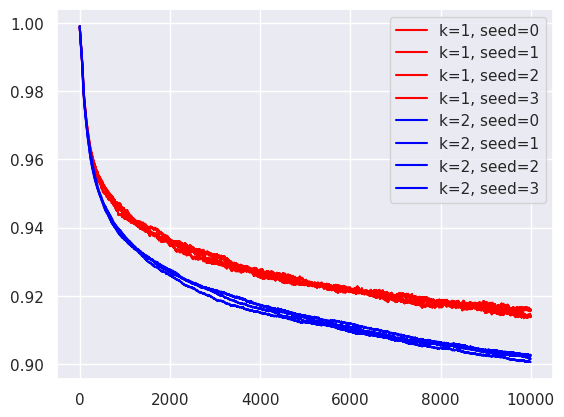

In [7]:
for k_nbrs in [1, 2]:
    for seed in range(4):
        save_dir = f"/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_{k_nbrs}_{seed}"
        data = util.load_pkl(save_dir, "data")
        pop = util.load_pkl(save_dir, "pop")
        plt.plot(data['loss'], label=f"k={k_nbrs}, seed={seed}", c='red' if k_nbrs==1 else 'blue')
plt.legend()
plt.show()


/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_1_0
/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_1_1
/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_1_2
/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_1_3
/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_2_0
/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_2_1
/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_2_2
/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_2_3


Text(0.5, 0.98, '256 Timesteps')

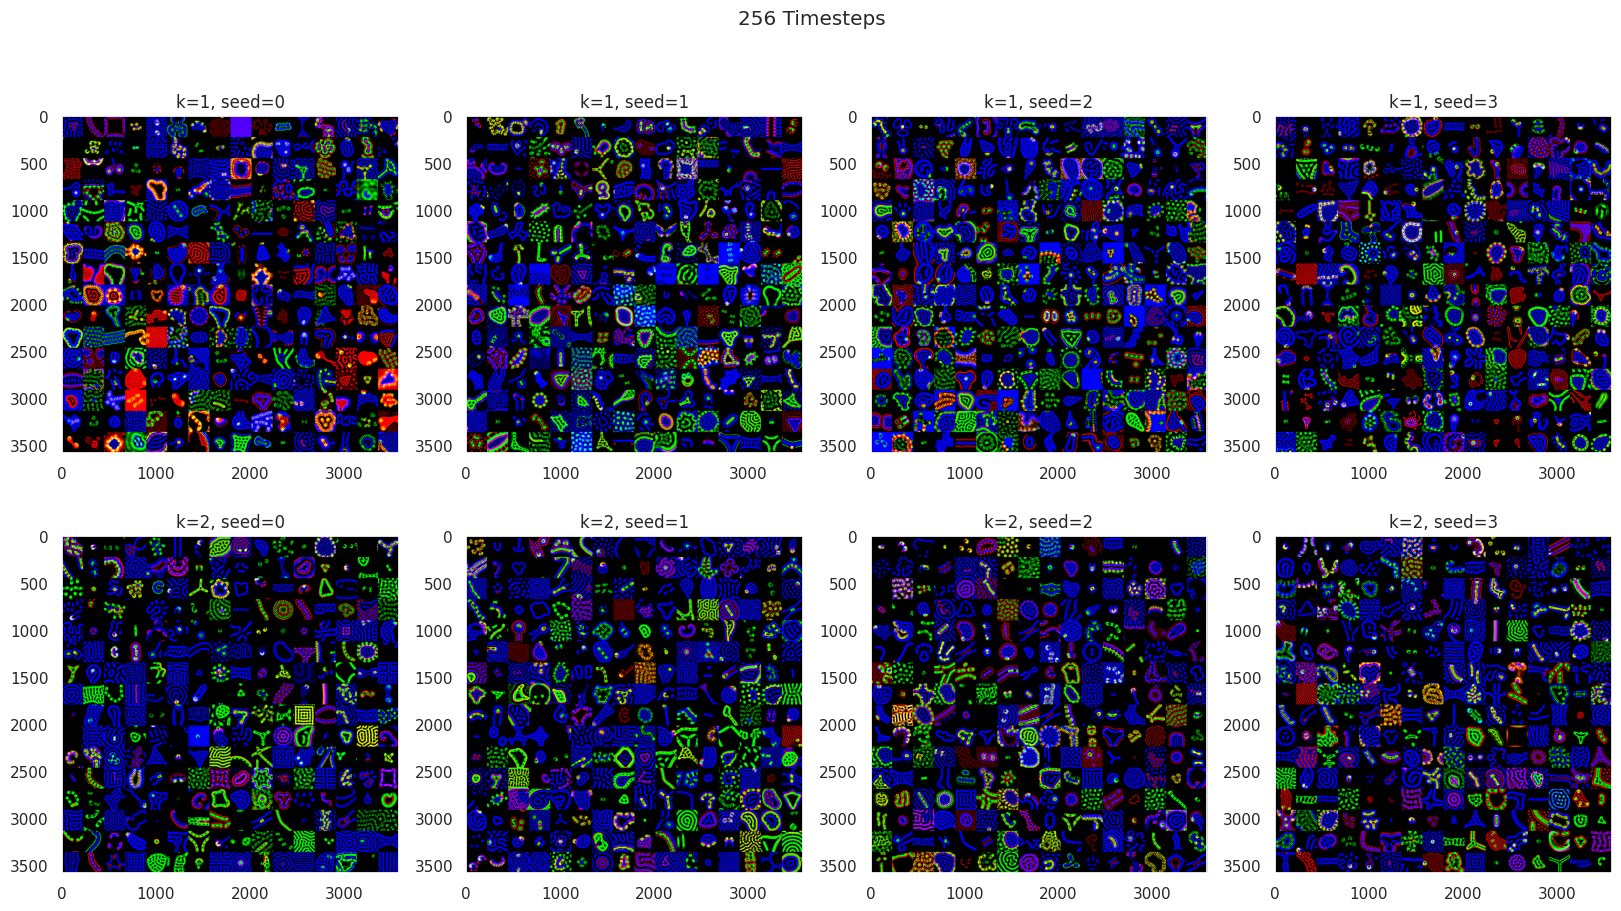

In [8]:
plt.figure(figsize=(20, 10))
iplt = 0
for k_nbrs in [1, 2]:
    for seed in range(4):
        save_dir = f"/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_256_{k_nbrs}_{seed}"
        print(save_dir)
        data = util.load_pkl(save_dir, "data")
        pop = util.load_pkl(save_dir, "pop")
        img = pop['img_final']
        iplt += 1
        plt.subplot(2, 4, iplt)
        plt.imshow(rearrange(img[:256], "(R C) H W D -> (R H) (C W) D", C=16))
        plt.grid(False)
        plt.title(f"k={k_nbrs}, seed={seed}")
plt.suptitle("256 Timesteps")

/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_1_0
/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_1_1
/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_1_2
/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_1_3
/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_2_0
/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_2_1
/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_2_2
/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_2_3


Text(0.5, 0.98, '1000 Timesteps')

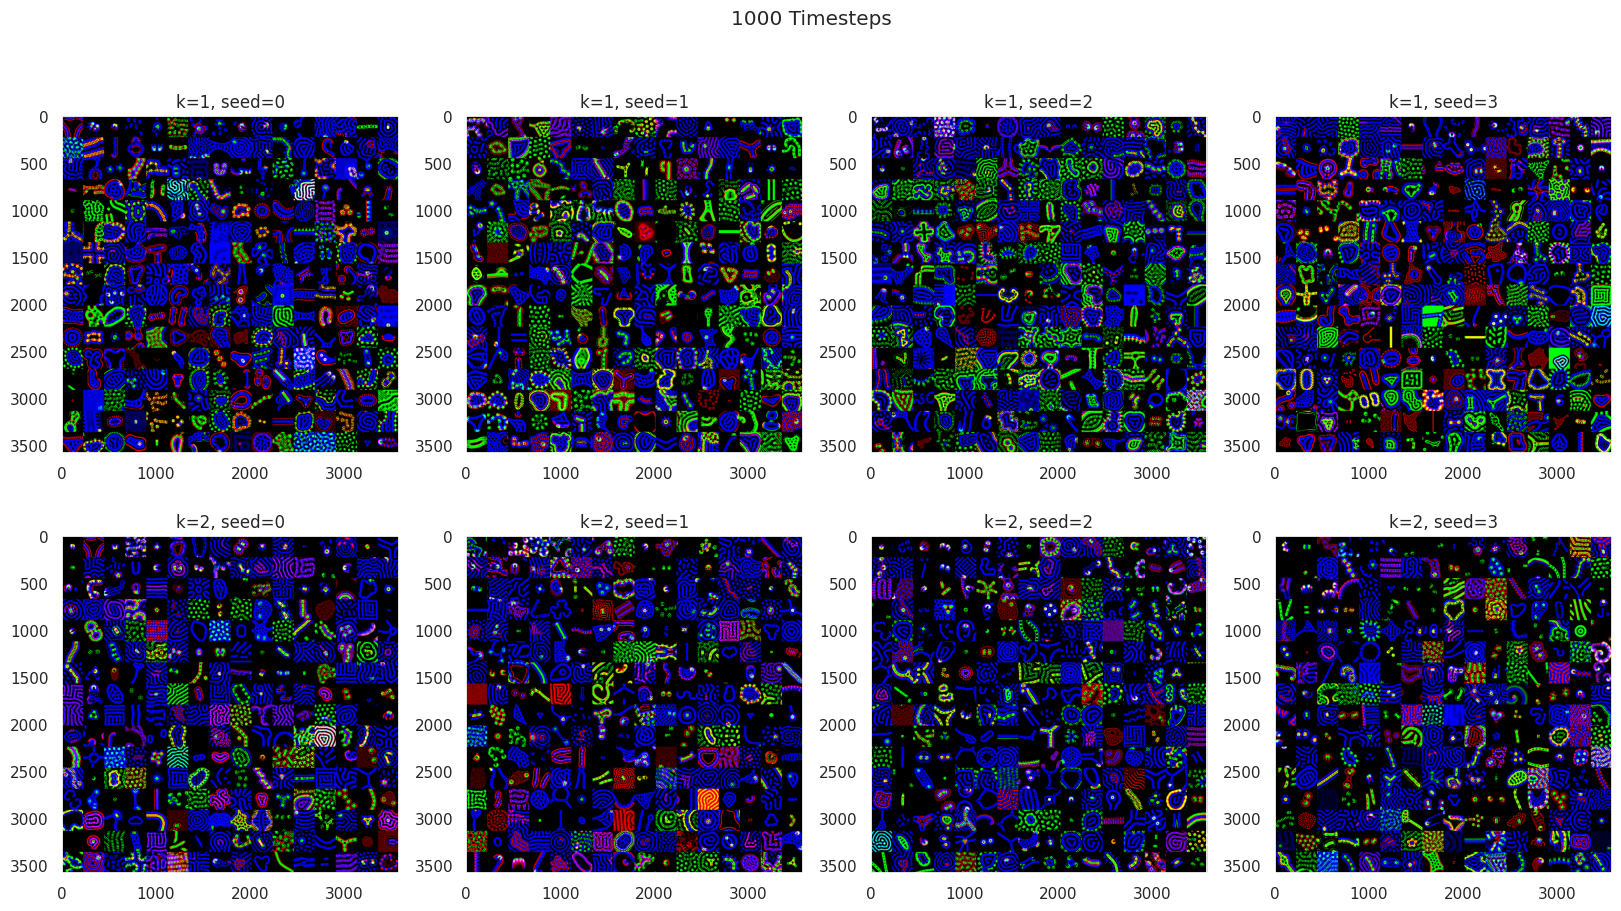

In [9]:
plt.figure(figsize=(20, 10))
iplt = 0
for k_nbrs in [1, 2]:
    for seed in range(4):
        save_dir = f"/home/akarsh_sakana_ai/nca-alife-data/illumination/lenia_1000_{k_nbrs}_{seed}"
        print(save_dir)
        data = util.load_pkl(save_dir, "data")
        pop = util.load_pkl(save_dir, "pop")
        img = pop['img_final']
        iplt += 1
        plt.subplot(2, 4, iplt)
        plt.imshow(rearrange(img[:256], "(R C) H W D -> (R H) (C W) D", C=16))
        plt.grid(False)
        plt.title(f"k={k_nbrs}, seed={seed}")
plt.suptitle("1000 Timesteps")

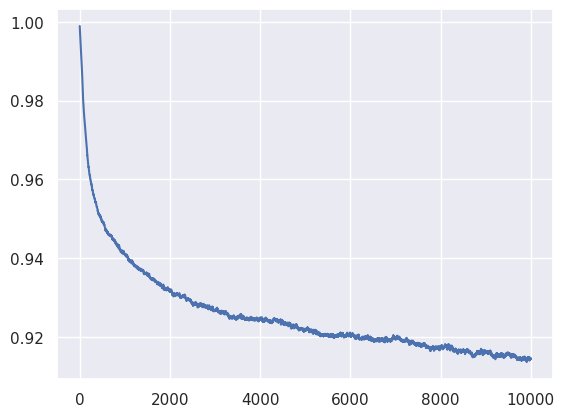

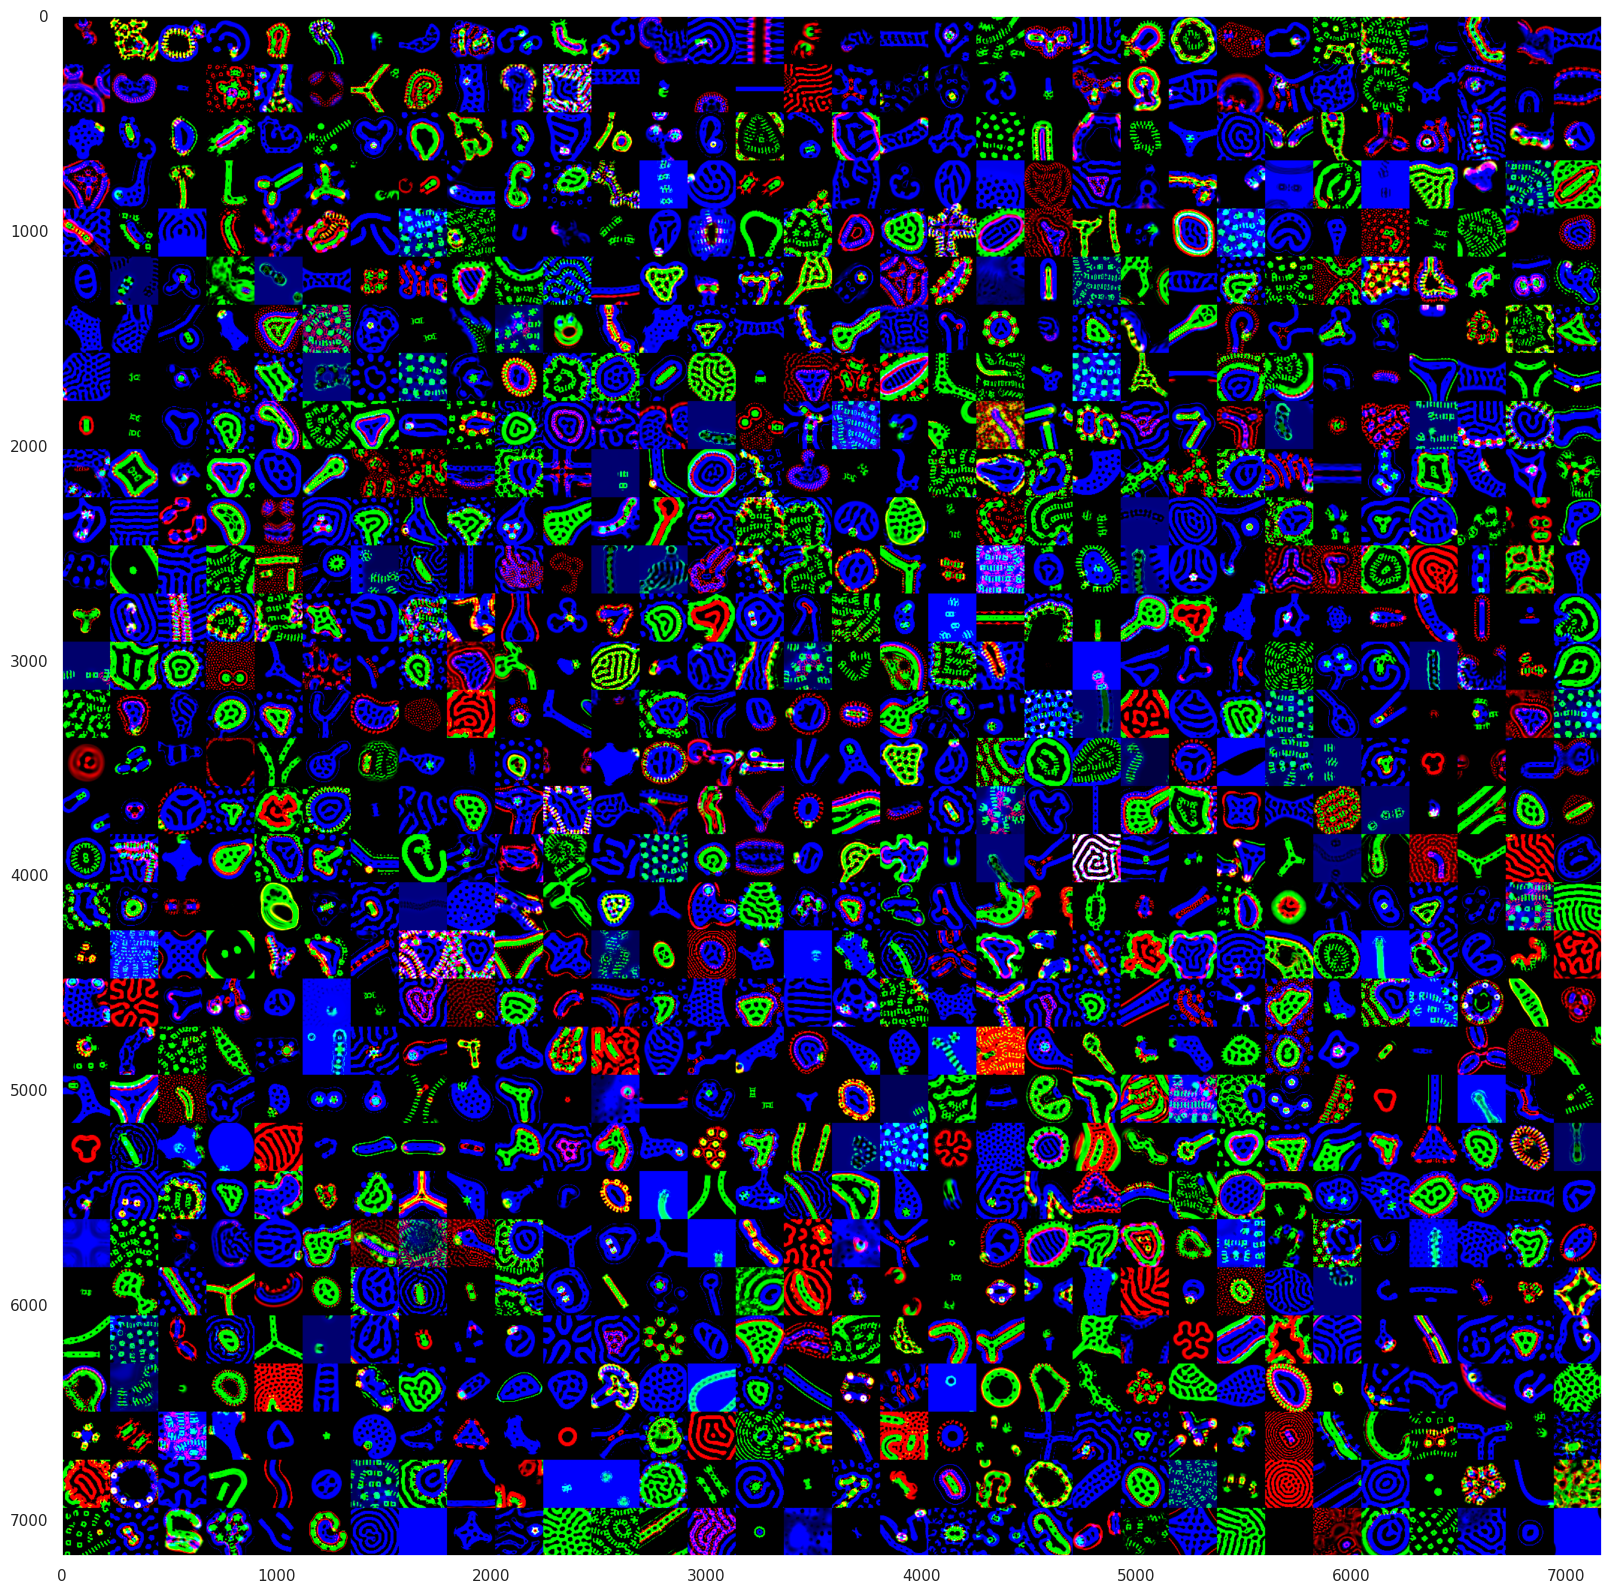

In [32]:
plt.plot(data['loss'])
img = pop['img_final']
plt.figure(figsize=(20, 20))
plt.imshow(rearrange(img, "(R C) H W D -> (R H) (C W) D", C=32))
plt.grid(False)
plt.show()

# Visualize Results

In [ ]:
import jax
import jax.numpy as jnp
from jax.random import split
import copy
from umap import UMAP
import imageio
import evosax

In [ ]:
from models.models_nca import NCA
from models.models_dnca import DNCA
from models.models_boids import Boids
from models.models_plife import ParticleLife
from models.models_lenia import Lenia
from models.models_plenia import ParticleLenia
from models.models_gol import GameOfLife

In [ ]:
df = []
for cfg in tqdm(cfgs):
    dfi = copy.copy(cfg)
    dfi['loss'] = util.load_pkl(cfg['save_dir'], "data")['loss'][-300:].mean().item()
    df.append(dfi)
df = pd.DataFrame(df)

In [ ]:
df

In [ ]:
def unroll_params(rng, params, sim, rollout_len=512, img_size=128, ret='vid'):
    def step(state, _rng):
        next_state = sim.step_state(_rng, state, params)
        return next_state, state
    state_init = sim.init_state(rng, params)
    state_final, state_vid = jax.lax.scan(step, state_init, split(rng, rollout_len))
    if ret=='vid':
        vid = jax.vmap(partial(sim.render_state, params=params, img_size=img_size))(state_vid)
        return vid
    elif ret=='img':
        img = sim.render_state(state_final, params=params, img_size=img_size)
        return img

In [ ]:
save_dirs

In [ ]:
sims = [
    Lenia(grid_size=128, center_phenotype=True, phenotype_size=64), # rollout steps=256
    ParticleLenia(n_particles=200, dt=0.1), # rollout_steps=1000
    NCA(grid_size=128, d_state=3, p_drop=0.5, dt=0.1), # rollout_steps=1000
    DNCA(grid_size=128, d_state=8, n_groups=1, identity_bias=0., temperature=1e-3), # rollout_steps=1000
    Boids(n_boids=128, n_nbrs=16, visual_range=0.1, speed=0.5, controller='network', dt=0.01, bird_render_size=0.015, bird_render_sharpness=40),
    ParticleLife(n_particles=5000, n_colors=6, search_space='beta+alpha', dt=2e-3, render_radius=1e-2), # rollout_steps=1000
    # GameOfLife(),
]

# rollout_lens = [256

In [ ]:
save_dir, sim = save_dirs[0], sims[0]
print(save_dir)
data = util.load_pkl(save_dir, 'data')
pop = util.load_pkl(save_dir, 'pop')
params = pop['params']
z = pop['z_img_final']
img_final = pop['img_final']

rng = jax.random.PRNGKey(0)
param_reshaper = evosax.ParameterReshaper(sim.default_params(rng))

img = []
unroll_fn = jax.jit(partial(unroll_params, sim=sim, rollout_len=256, img_size=64, ret='img'))
for p in tqdm(params[::1]):
    p = param_reshaper.reshape_single(p)
    img.append(unroll_fn(rng, p))
img = jnp.stack(img)

vid = []
unroll_fn = jax.jit(partial(unroll_params, sim=sim, rollout_len=256, img_size=64, ret='vid'))
for p in tqdm(params[::len(params)//256]):
    p = param_reshaper.reshape_single(p)
    vid.append(unroll_fn(rng, p))
vid = jnp.stack(vid)

img = rearrange(img, "(R C) H W D -> (R H) (C W) D", R=32)
img = np.array((img*255).astype(jnp.uint8))
vid = rearrange(vid, "(R C) T H W D -> T (R H) (C W) D", R=16)
vid = np.array((vid*255).astype(jnp.uint8))

In [ ]:
plt.imsave(f"{save_dir}/out_grid.png", img)
imageio.mimwrite(f"{save_dir}/out_grid.mp4", vid, fps=30, codec='libx264')

In [ ]:
for save_dir, sim in zip(save_dirs[1:], sims[1:]):
    print(save_dir)
    data = util.load_pkl(save_dir, 'data')
    pop = util.load_pkl(save_dir, 'pop')
    params = pop['params']
    z = pop['z_img_final']
    img_final = pop['img_final']
    
    rng = jax.random.PRNGKey(0)
    param_reshaper = evosax.ParameterReshaper(sim.default_params(rng))
    
    img = []
    unroll_fn = jax.jit(partial(unroll_params, sim=sim, rollout_len=1000, img_size=32, ret='img'))
    for p in tqdm(params[::1]):
        p = param_reshaper.reshape_single(p)
        img.append(unroll_fn(rng, p))
    img = jnp.stack(img)
    
    vid = []
    unroll_fn = jax.jit(partial(unroll_params, sim=sim, rollout_len=1000, img_size=32, ret='vid'))
    for p in tqdm(params[::len(params)//256]):
        p = param_reshaper.reshape_single(p)
        vid.append(unroll_fn(rng, p))
    vid = jnp.stack(vid)
    
    img = rearrange(img, "(R C) H W D -> (R H) (C W) D", R=32)
    img = np.array((img*255).astype(jnp.uint8))
    vid = rearrange(vid, "(R C) T H W D -> T (R H) (C W) D", R=16)
    vid = np.array((vid*255).astype(jnp.uint8))
    
    plt.imsave(f"{save_dir}/out_grid.png", img)
    imageio.mimwrite(f"{save_dir}/out_grid.mp4", vid, fps=30, codec='libx264')

In [ ]:
img.shape, vid.shape

In [ ]:
plt.imshow(rearrange(vid[:64, -1], "(R C) H W D -> (R H) (C W) D", R=8))
plt.grid(False)
plt.show()

In [ ]:
img.shape

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.show()

In [ ]:
# unroll_fn = partial(unroll_params, sim=sim, rollout_len=512, img_size=128, ret='img')

In [ ]:
# jax.vmap(unroll_fn, in_axes=(None, 0))(rng, params)

In [ ]:
for save_dir, sim in zip(save_dirs, sims):
    print(save_dir)
    data = util.load_pkl(save_dir, 'data')
    pop = util.load_pkl(save_dir, 'pop')

    z = pop['z_img_final']
    img_final = pop['img_final']
    z_1d = UMAP(n_components=1, metric='cosine').fit_transform(z)
    z_2d = UMAP(n_components=2, metric='cosine').fit_transform(z)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(121); plt.plot(data['loss'])
    plt.subplot(122); plt.scatter(*z_2d.T, c=z_1d[:, 0], s=10)
    plt.show()

    idx = z_1d.flatten().argsort()
    img = rearrange(img_final[idx], "(R C) H W D -> (R H) (C W) D", C=32).astype(np.uint8)
    plt.figure(figsize=(30, 30))
    plt.imshow(img)
    plt.grid(False)
    
    plt.show()
    

In [ ]:
save_dirs = [
    "/home/akarshkumar0101/nca-alife-data/diversity_plenia/",
    "/home/akarshkumar0101/nca-alife-data/diversity_boids/",
    "/home/akarshkumar0101/nca-alife-data/diversity_nca/",
    # "/home/akarshkumar0101/nca-alife-data/diversity_dnca/",
]

In [ ]:
for save_dir in save_dirs:
    print(save_dir)
    data = util.load_pkl(save_dir, 'data')
    pop = util.load_pkl(save_dir, 'pop')
    z = pop['z_img_final']
    img_final = pop['img_final']
    z_1d = UMAP(n_components=1, metric='cosine').fit_transform(z)
    z_2d = UMAP(n_components=2, metric='cosine').fit_transform(z)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(121); plt.plot(data['loss'])
    plt.subplot(122); plt.scatter(*z_2d.T, c=z_1d[:, 0], s=10)
    plt.show()
    
    idx = z_1d.flatten().argsort()
    img = rearrange(img_final[idx], "(R C) H W D -> (R H) (C W) D", R=32).astype(np.uint8)
    plt.figure(figsize=(30, 30))
    plt.imshow(img)
    plt.grid(False)
    
    plt.show()

In [ ]:
from models.models_boids import Boids
import evosax
save_dir = save_dirs[1]
sim = Boids(n_boids=128, n_nbrs=16, visual_range=0.1, speed=0.5, controller='network', dt=0.01,
            bird_render_size=0.015, bird_render_sharpness=40)
data = util.load_pkl(save_dir, 'data')
pop = util.load_pkl(save_dir, 'pop')

z = pop['z_img_final']
img_final = pop['img_final']
z_1d = UMAP(n_components=1, metric='cosine').fit_transform(z)
z_2d = UMAP(n_components=2, metric='cosine').fit_transform(z)

idx = z_1d.flatten().argsort()

rng = jax.random.PRNGKey(0)
param_reshaper = evosax.ParameterReshaper(sim.default_params(rng))

In [ ]:
unroll_fn = partial(unroll_params, sim=sim, rollout_len=1000, img_size=64, ret='vid')
unroll_fn = jax.jit(unroll_fn)
vids = []
for params in tqdm(pop['params'][::4]):
    params = param_reshaper.reshape_single(params)
    rng = jax.random.PRNGKey(0)
    vid = unroll_fn(rng, params)
    vids.append(vid)

In [ ]:
vids = jnp.stack(vids)

In [ ]:
vids = np.array((vids*255).astype(jnp.uint8))

In [ ]:
vids.shape, vids.dtype

In [ ]:
vids = rearrange(vids, "(R C) T H W D -> T (R H) (C W) D", R=16)

In [ ]:
vids.shape

In [ ]:
import imageio
imageio.mimwrite("/home/akarshkumar0101/nca-alife-data/diversity_boids/vid.mp4", vids, fps=30, codec='libx264')

In [ ]:
from models.models_plenia import ParticleLenia
import evosax
save_dir = save_dirs[1]
sim = Boids(n_boids=128, n_nbrs=16, visual_range=0.1, speed=0.5, controller='network', dt=0.01,
            bird_render_size=0.015, bird_render_sharpness=40)
data = util.load_pkl(save_dir, 'data')
pop = util.load_pkl(save_dir, 'pop')

z = pop['z_img_final']
img_final = pop['img_final']
z_1d = UMAP(n_components=1, metric='cosine').fit_transform(z)
z_2d = UMAP(n_components=2, metric='cosine').fit_transform(z)

idx = z_1d.flatten().argsort()

rng = jax.random.PRNGKey(0)
param_reshaper = evosax.ParameterReshaper(sim.default_params(rng))

In [ ]:
for save_dir in save_dirs[:1]:
    print(save_dir)
    data = util.load_pkl(save_dir, 'data')
    pop = util.load_pkl(save_dir, 'pop')
    z = pop['z_img_final']
    img_final = pop['img_final']

In [ ]:
from clip_jax import MyFlaxCLIP
clip_model = MyFlaxCLIP()


In [ ]:
prompt = "a circle"
z_text = clip_model.embed_text(prompt)

In [ ]:
z.shape, z_text.shape

In [ ]:
scores = (z@z_text.T).flatten()

In [ ]:
scores.shape

In [ ]:
plt.imshow(img_final[scores.argmax()].astype(np.uint8))

In [ ]:
def unroll_params(rng, params, sim, rollout_len=512, img_size=128, ret='vid'):
    def step(state, _rng):
        next_state = sim.step_state(_rng, state, params)
        return next_state, state
    state_init = sim.init_state(rng, params)
    state_final, state_vid = jax.lax.scan(step, state_init, split(rng, rollout_len))
    if ret=='vid':
        vid = jax.vmap(partial(sim.render_state, params=params, img_size=img_size))(state_vid)
        return vid
    elif ret=='img':
        img = sim.render_state(state_final, params=params, img_size=img_size)
        return img

In [ ]:
sns.lineplot(data=df, x='k_nbrs', y='loss')
sns.scatterplot(data=df, x='k_nbrs', y='loss')
plt.xscale('log')

In [ ]:
for cfg in cfgs[:5]:
    print(cfg)
    # plt.figure(figsize=(20, 5))
    loss = util.load_pkl(cfg['save_dir'], 'data')['loss']
    # plt.plot(loss)
    # plt.show()
    
    pop = util.load_pkl(cfg['save_dir'], 'pop')
    z = pop['z_img_final']
    img_final = pop['img_final']
    z_1d = UMAP(n_components=1, metric='cosine').fit_transform(z)
    z_2d = UMAP(n_components=2, metric='cosine').fit_transform(z)
    
    # plt.scatter(*z_2d.T, c=z_1d[:, 0], s=10)
    # plt.show()
    
    idx = z_1d.flatten().argsort()
    img = rearrange(img_final[idx], "(R C) H W D -> (R H) (C W) D", R=32).astype(np.uint8)
    plt.figure(figsize=(30, 30))
    plt.imshow(img)
    plt.grid(False)

    plt.title(f"sigma1={cfg['sigma1']}\nsigma2={cfg['sigma2']}", fontsize=20)
    plt.show()

In [ ]:
for cfg in cfgs[::4]:
    print(cfg)
    plt.figure(figsize=(20, 5))
    loss = util.load_pkl(cfg['save_dir'], 'data')['loss']
    plt.plot(loss)
    plt.show()
    
    pop = util.load_pkl(cfg['save_dir'], 'pop')
    z = pop['z_img_final']
    img_final = pop['img_final']
    z_1d = UMAP(n_components=1, metric='cosine').fit_transform(z)
    z_2d = UMAP(n_components=2, metric='cosine').fit_transform(z)
    
    plt.scatter(*z_2d.T, c=z_1d[:, 0], s=10)
    plt.show()
    
    idx = z_1d.flatten().argsort()
    img = rearrange(img_final[idx], "(R C) H W D -> (R H) (C W) D", R=32).astype(np.uint8)
    plt.figure(figsize=(30, 30))
    plt.imshow(img)
    plt.grid(False)

    plt.title(f"sigma1={cfg['sigma1']}\nsigma2={cfg['sigma2']}", fontsize=20)
    plt.show()

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
sns.lineplot(data=df, x="sigma2", y="loss", hue='sigma1')
plt.subplot(122)
sns.lineplot(data=df, x="sigma1", y="loss", hue='sigma2')

In [ ]:
for cfg in cfgs[::4]:
    print(cfg)
    plt.figure(figsize=(20, 5))
    loss = util.load_pkl(cfg['save_dir'], 'data')['loss']
    plt.plot(loss)
    plt.show()
    
    pop = util.load_pkl(cfg['save_dir'], 'pop')
    z = pop['z_img_final']
    img_final = pop['img_final']
    z_1d = UMAP(n_components=1, metric='cosine').fit_transform(z)
    z_2d = UMAP(n_components=2, metric='cosine').fit_transform(z)
    
    plt.scatter(*z_2d.T, c=z_1d[:, 0], s=10)
    plt.show()
    
    idx = z_1d.flatten().argsort()
    img = rearrange(img_final[idx], "(R C) H W D -> (R H) (C W) D", R=32).astype(np.uint8)
    plt.figure(figsize=(30, 30))
    plt.imshow(img)
    plt.grid(False)

    plt.title(f"sigma1={cfg['sigma1']}\nsigma2={cfg['sigma2']}", fontsize=20)
    plt.show()

In [ ]:
for cfg in cfgs[1::4]:
    print(cfg)
    plt.figure(figsize=(20, 5))
    loss = util.load_pkl(cfg['save_dir'], 'data')['loss']
    plt.plot(loss)
    plt.show()
    
    pop = util.load_pkl(cfg['save_dir'], 'pop')
    z = pop['z_img_final']
    img_final = pop['img_final']
    z_1d = UMAP(n_components=1, metric='cosine').fit_transform(z)
    z_2d = UMAP(n_components=2, metric='cosine').fit_transform(z)
    
    plt.scatter(*z_2d.T, c=z_1d[:, 0], s=10)
    plt.show()
    
    idx = z_1d.flatten().argsort()
    img = rearrange(img_final[idx], "(R C) H W D -> (R H) (C W) D", R=32).astype(np.uint8)
    plt.figure(figsize=(30, 30))
    plt.imshow(img)
    plt.grid(False)
    plt.show()

In [ ]:
z_all = []
idx = []
for cfg in cfgs[0::4]+cfgs[1::4]:
    pop = util.load_pkl(cfg['save_dir'], 'pop')
    z = pop['z_img_final']
    z_all.append(z)

In [ ]:
z_all = np.concatenate(z_all)
z_all.shape

In [ ]:
z_all_2d = UMAP(n_components=2, metric='cosine').fit_transform(z_all)
z_all_2d.shape

In [ ]:
idx = repeat(np.arange(10), "R -> (R N)", N=1024)

In [ ]:
plt.figure(figsize=(10, 10))
for i, x in enumerate(z_all_2d.reshape(10, 1024, 2)):
    plt.scatter(*x.T, label=f'run cfg {i}', s=10.)
plt.legend()
plt.show()

In [ ]:
cfg = cfgs[::4][2]
cfg

In [ ]:
pop = util.load_pkl(cfg['save_dir'], 'pop')

In [ ]:
pop.keys()

In [ ]:
i1, i2 = 0, 1000
params1 = pop['params'][i1]
params2 = pop['params'][i2]

In [ ]:
from models_lenia import Lenia
from jax.random import split
from clip_jax import MyFlaxCLIP
clip_model = MyFlaxCLIP()

sim = Lenia(grid_size=128, center_phenotype=True, phenotype_size=64, start_pattern="5N7KKM")

@jax.jit
def unroll_params(rng, params):
    def step(state, _rng):
        next_state = sim.step_state(_rng, state, params)
        return next_state, state
    state_init = sim.init_state(rng, params)
    state_final, state_vid = jax.lax.scan(step, state_init, split(rng, 256))

    img_init = sim.render_state(state_init, params=params, img_size=224)
    img = sim.render_state(state_final, params=params, img_size=224)
    z_img = clip_model.embed_img(img)
    return dict(img_init=img_init, img=img, z_img=z_img)

In [ ]:
rng = jax.random.PRNGKey(0)
z1 = unroll_params(rng, params1)['z_img']
z2 = unroll_params(rng, params2)['z_img']

In [ ]:
zs = []
ts = np.linspace(0, 1, 500)
for t in tqdm(ts):
    params = params1 + t*(params2-params1)
    z = unroll_params(rng, params)['z_img']
    zs.append(z)

In [ ]:
zs = jnp.stack(zs)

In [ ]:
zs.shape

In [ ]:
plt.plot(ts, (zs@z2))
plt.xlabel("Sweeping from params1 to params2")
plt.ylabel("CLIP alignment to params2")